# 股票价格预测 LSTM

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2023-07-21 10:45:42.759793: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df=pd.read_csv('../dataset/TATAGLOBAL.csv')
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2019-01-04,210.60,214.90,210.00,213.50,213.80,1213181.0,2583.05
1,2019-01-03,214.95,215.35,209.90,210.55,210.05,2096553.0,4433.50
2,2019-01-02,219.00,220.35,213.60,214.20,214.60,1081778.0,2340.31
3,2019-01-01,219.95,221.05,218.05,218.95,219.10,716275.0,1571.63
4,2018-12-31,222.00,223.65,218.85,219.55,219.40,965858.0,2131.09


Text(0.5, 1.0, 'Close Price history')

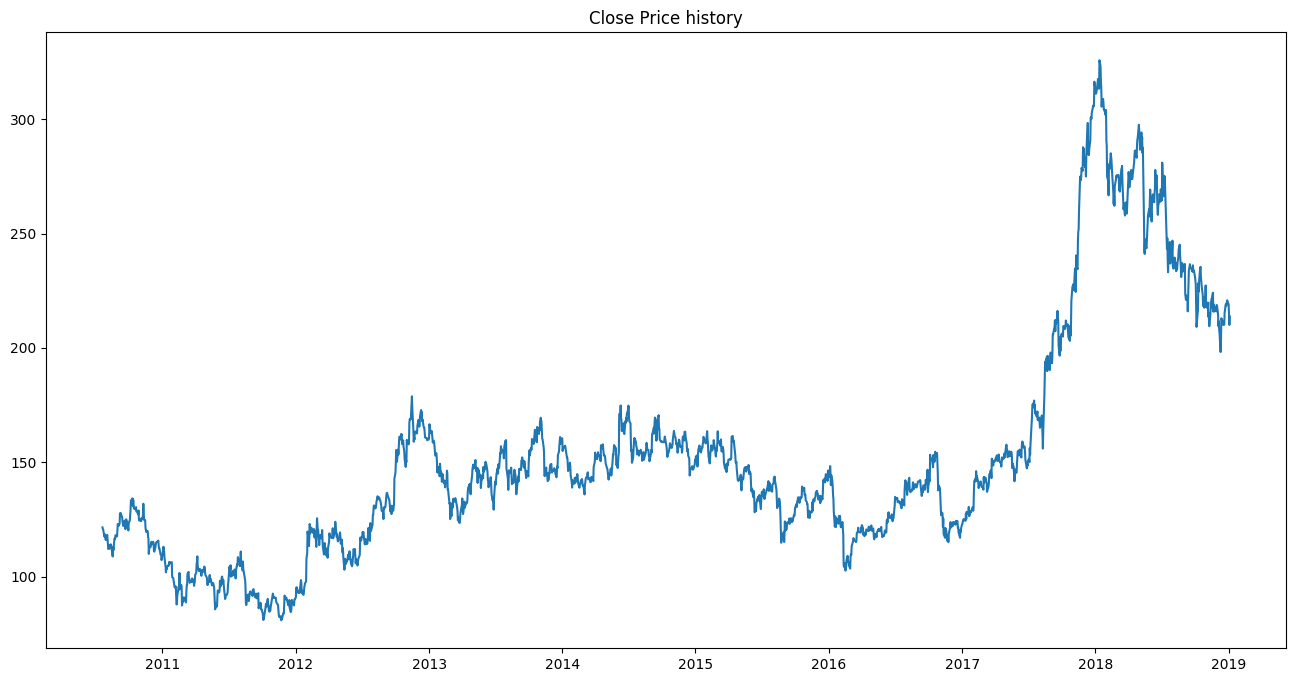

In [3]:
# Display stock close price history
df['Date']=pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df['Close'],label='Close Price history')
plt.title('Close Price history')

In [9]:
# sort the dataset on date time, and filter 'Date' and 'Close' columns
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
print(len(df))

for i in range(0,len(data)):
    new_dataset['Date'][i]=data['Date'][i]
    new_dataset['Close'][i]=data['Close'][i]

2100


In [10]:

train_size = 987
print(f"train_size[{train_size}]")

# set Date as index, and drop Date column
new_dataset.index = new_dataset.Date
new_dataset.drop("Date", axis=1, inplace=True)
print(new_dataset.head())

final_dataset = new_dataset.values

# normalize the new filtered dataset to range (0, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_dataset)

# split train and valid data
train_data, valid_data = (
    final_dataset[:train_size,:],
    final_dataset[train_size:,:],
)

# Construct train arrays
X_train, y_train = [], []

for i in range(60, len(train_data)):
    X_train.append(scaled_data[i - 60 : i, 0])
    y_train.append(scaled_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

train_size[987]
             Close
Date              
2010-07-21  121.55
2010-07-22   120.9
2010-07-23  120.65
2010-07-26   117.6
2010-07-27  118.65
(927, 60)
(927, 60, 1)


In [11]:
# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1))
)
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs = new_dataset[len(new_dataset) - len(valid_data) - 60 :].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)
print(inputs.shape)

lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

2023-07-21 10:47:28.680507: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 10:47:28.696344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 10:47:28.696519: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-21 10:47:28.697013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operation

(1173, 1)


2023-07-21 10:47:30.357641: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2023-07-21 10:47:30.380800: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-21 10:47:30.401036: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f7265fd56a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-21 10:47:30.401070: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-07-21 10:47:30.403937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-21 10:47:30.485878: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the l

927/927 - 7s - loss: 9.0007e-04 - 7s/epoch - 7ms/step


In [12]:
# take a sample of a dataset to make stock price predictions using the LSTM
# model
X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)

print(X_test.shape)
X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

predicted_closing_price=lstm_model.predict(X_test)
# Restore origin data from normalized output
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

(1113, 60)
(1113, 60, 1)
35/35 [==============================] - 1s 2ms/step


In [13]:
# save the lstm model
lstm_model.save('model.h5')

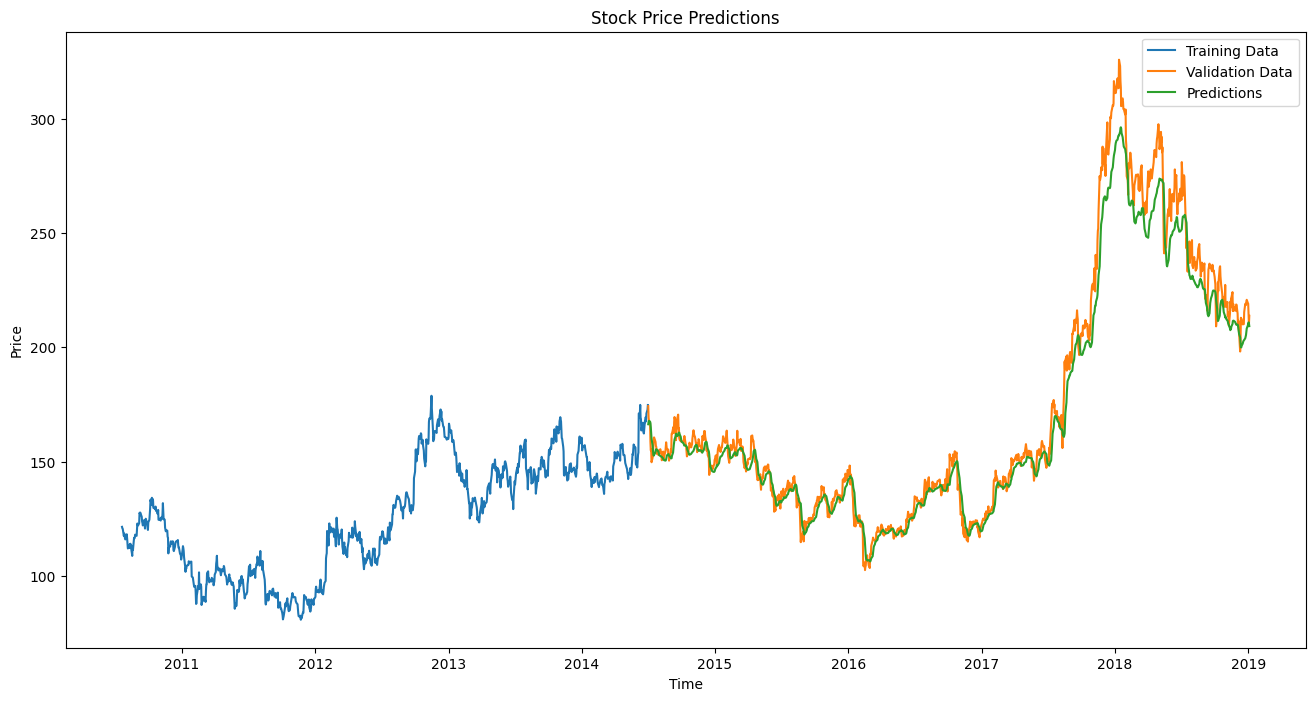

In [19]:
# visualize the predicted stock costs with actual stock costs
train_data = new_dataset[:train_size].copy()
valid_data = new_dataset[train_size:].copy()
valid_data.loc[:, "Predictions"] = predicted_closing_price

plt.figure(figsize=(16, 8))
plt.plot(train_data["Close"], label="Training Data")
plt.plot(valid_data["Close"], label="Validation Data")
plt.plot(valid_data["Predictions"], label="Predictions")
plt.title("Stock Price Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend(loc="best")
plt.show()